In [4]:
# simple feed forward network with ReLU example
import numpy as np

if __name__=='__main__':
    # parameters
    inp_size = 10 # input size
    etha = 0.1 # learning rate
    niter = 100

    # input
    x = np.zeros((1, inp_size)) # input
    x = [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]

    # model parameters
    W1 = np.random.randn(inp_size, inp_size)*0.01 # input to hidden
    W2 = np.random.randn(inp_size, inp_size)*0.01 # hidden to output
    b1 = np.zeros((1, inp_size)) # inp-hidden bias
    b2 = np.zeros((1, inp_size)) # hidden-out bias
    
    for ictr in range(niter):

        # forward pass
        h1 = np.dot(x, W1) + b1
        h1 = np.maximum(h1, 0, h1) # ReLU
        o2 = np.dot(h1, W2) + b2
        #print(o2)

        # backward pass
        y = [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]
        h1 = np.dot(x, W1) + b1
        dW1 = - etha * (o2 - y) * np.maximum(h1, 0, h1)
        dW2 = dW1 * ((h1 > 0) * 1.) * x
        
        W1 += dW1
        W2 += dW2
        
    print(dW1)
    print(dW2)
    # forward pass
    h1 = np.dot(x, W1) + b1
    h1 = np.maximum(h1, 0, h1) # ReLU
    o2 = np.dot(h1, W2) + b2
    print(o2)

[[-0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
   1.81831121e-07 -0.00000000e+00  0.00000000e+00  1.12753895e-08
  -0.00000000e+00  0.00000000e+00]]
[[-0.  0.  0. -0.  0. -0.  0.  0. -0.  0.]]
[[ 8.04376336e-05 -5.65068638e-05 -7.77747678e-05  1.29369767e-04
  -1.76518582e-04  7.90246546e-05 -2.17529744e-04 -1.93975479e-05
   4.26013069e-05 -6.47007077e-05]]


In [ ]:
# key-value memory network

import numpy as np
from gensim import corpora
import math

def softmax(x):
    ex = np.exp(x - np.max(x))
    return ex / ex.sum()

def lj(j, J, k, d): 
    return (1-j/J)-(k/d)*(1-2*j/J)

if __name__=="__main__":
    # load input data
    #data = open('input1.txt', 'r').read() # input text file: sentences separated by .

    # hyperparameters
    d_embed = 0 # embedding dimension
    lr = 1.8 # learning rate
    
    # input to memory embedding mi = A * xi + tA
        #stoplist = set('for a of the and to in'.split())
    stoplist = []
    doc_raw = 'Mary moved to the bathroom. John went to the hallway.'
    
    # create key-value pairs
    
    # embed query
    query_raw = 'Where is Mary?'
    document = doc_raw.lower().split('.')
    document.append(query_raw.lower())
    #senttoken = [ [word for word in sentence.lower().split(' ') if word not in stoplist] for sentence in document ]
    senttoken = []
    for idoc in range(len(document)):
        thissen = document[idoc].lower().split(' ')
        tokendoc = []
        for idx, thiswrd in enumerate(thissen):
            tokendoc.append(thiswrd + '_' + str(idoc))
        senttoken.append(tokendoc)
    dictionary = corpora.Dictionary(senttoken)
    print(dictionary.token2id)
    document.pop(len(document)-1) # query at the end of document
    d_embed = len(dictionary)
    #voc = 0 # size of vocabulary
    #for d in document:
        #print(d)
        #if len(d) == 0:
            #document.remove(d)
        #voc = max(voc, len(d.split()))
    voc = d_embed
    n_memories = len(document)
    #print(voc)
    #print(document)

    # initiate weigth matrices
    A = np.random.randn(d_embed, voc)*0.01 # input to memory embedding
    tA = np.random.randn(d_embed)*0.01 # temporal encoding A
    B = np.random.randn(d_embed, voc)*0.01 # query embedding
    tB = np.random.randn(d_embed)*0.01 # temporal encoding B
    C = np.random.randn(d_embed, voc)*0.01 # output to memory embedding
    tC = np.random.randn(d_embed)*0.01 # temporal encoding C
    W = np.random.randn(voc, d_embed)*0.01 # final weight matrix
    
    # memory for Adagrad
    mA = np.zeros_like(A)
    mtA = np.zeros_like(tA)
    mB = np.zeros_like(B)
    mtB = np.zeros_like(tB)
    mC = np.zeros_like(C)
    mtC = np.zeros_like(tC)
    mW = np.zeros_like(W)

    x = np.zeros((n_memories, voc))
    for i in range(n_memories):
        for j in range(len(senttoken[i])):
            x[i][j] = dictionary.token2id[senttoken[i][j]]
         
    for iterctr in range(1000):

        # forward pass
        
        # embedding simple: m_i = A_ij * x_ij + T_A_j
        m = np.zeros((n_memories, d_embed))
        for i in range(n_memories):
            m[i] = np.dot(A, x[i].T) + tA # simple embedding
            #m[i][j] = lj(j,len(document[i]),j,d_embed) * A[i][j] * x[i][j] + tA[j] # with positional encoding

        # query embedding u = B * q + tB
        q = np.zeros(voc)
        u = np.zeros(d_embed)
        thissent = senttoken[1]
        for j in range(len(thissent)):
            q[j] = dictionary.token2id[thissent[j]]
        u = np.dot(B, q) + tB

        # match of query with memory p = softmax(u * mi) for all i
        p = np.zeros((n_memories, d_embed))
        p = softmax(np.dot(u, m.T))

        # output corresponding to input xi: ci = C * xi + tC
        c = np.zeros((n_memories, d_embed))
        for i in range(n_memories):
            c[i] = np.dot(C, x[i].T) + tC

        # response vector from memory o = sum pi * ci
        o = np.zeros(d_embed)
        o = np.dot(p.T, c)

        # predicted label a = softmax( W * (o + u))
        a_predict = softmax(np.dot(W, (o + u)))
        #print(a_predict)

        # backpropagation

        dA = np.zeros_like(A)
        dB = np.zeros_like(B)
        dC = np.zeros_like(C)
        dW = np.zeros_like(W)
        dtA = np.zeros_like(tA)
        dtB = np.zeros_like(tB)
        dtC = np.zeros_like(tC)

        truth = np.zeros_like(tA)
        truth[0] = 1 # answer
        dy = a_predict - truth
        # dA = dy a_predict * (1-a_predict) W sumi p[i] (1-p[i]) ( u.T * 1A * x[i]) c[i]
        #print('V: %d' % (voc))
        #print('d: %d', (d_embed))
        ABCunit = np.pad(np.identity(voc), ((0,d_embed-voc),(0,0)), 'constant', constant_values=(0))
        Wunit = np.pad(np.identity(voc), ((0,0), (0,d_embed-voc)), 'constant', constant_values=(0))
        tunit = np.ones_like(tA)

        dEAtmp = 0.
        for i in range(n_memories):
            dEAtmp += p[i]*(1.-p[i])*np.dot(np.dot(u, np.dot(ABCunit, x[i].T)), c[i])
        dEAtmp = W * dEAtmp
        dA = (np.dot(dy, a_predict * (1-a_predict)) * dEAtmp).T
        #print(dA)

        # dB = dy a_predict * (1-a_predict) W ( sumi p[i] (1-p[i]) ((1B q).T m[i]) c[i] + 1B q)
        dEAtmp = 0.
        for i in range(n_memories):
            dEAtmp += p[i]*(1.-p[i])*np.dot(np.dot(np.dot(ABCunit, q), m[i]), c[i])
        dEAtmp = W * dEAtmp
        dB = (np.dot(dy, a_predict*(1-a_predict)) * dEAtmp).T
        #print(dB)

        # dC = dy a_predict * (1-a_predict) W sumi p[i] 1C x[i]
        dEAtmp = 0.
        for i in range(n_memories):
            dEAtmp += p[i]*np.dot(ABCunit, x[i])
        dEAtmp = W * dEAtmp
        dC = (np.dot(dy, a_predict*(1-a_predict)) * dEAtmp).T
        #print(dC)

        # dW = dy a_predict * (1-a_predict) (o + u)
        dW = (np.dot(dy, a_predict*(1-a_predict)) * Wunit * (o + u))
        #print(dW)   

        # dtA = dy a_predict * (1-a_predict) W ( sumi p[i] (1-p[i]) (u.T 1tA) c[i])
        dEAtmp = 0.
        for i in range(n_memories):
            dEAtmp += p[i]*(1.-p[i])*np.dot(np.dot(u.T, tunit), c[i])
        dtA = (np.dot(dy * a_predict * (1-a_predict), W) * dEAtmp).T
        #print(dtA)

        # dtB = dy a_predict * (1-a_predict) W ( sumi p[i] (1-p[i]) ((1tB).T m[i] c[i]) + 1tB)
        dEAtmp = 0.
        for i in range(n_memories):
            dEAtmp += p[i]*(1.-p[i])*(np.dot(np.dot(tunit.T, m[i]), c[i]) + tunit)
        dtB = (np.dot(dy * a_predict * (1-a_predict), W) * dEAtmp).T
        #print(dtB)

        # dtC = dy a_predict * (1-a_predict) W ( sumi p[i] 1tC )
        dEAtmp = 0.
        for i in range(n_memories):
            dEAtmp += p[i]*tunit
        dtC = (np.dot(dy * a_predict * (1-a_predict), W) * dEAtmp).T
        #print(dtC)

        # maybe clip ?
        for dweights in [dA,dB,dC,dW,dtA,dtB,dtC]:
            np.clip(dweights, -5., 5., out=dweights) # exploding gradients (but seems well-behaved enough)

        # update weights with Adagrad
        for weights, dweights, memwghts in zip([A,B,C,W,tA,tB,tC], [dA,dB,dC,dW,dtA,dtB,dtC], [mA,mB,mC,mW,mtA,mtB,mtC]):
            memwghts += dweights * dweights
            #weights += -lr * dweights / np.sqrt(memwghts + 1.e-8)
            weights += -lr * dweights

        #print(A)
    print(a_predict)
    #print(np.argmax(a_predict))
    print(dictionary[np.argmax(a_predict)])

In [3]:
# prepare text file as corpus (lower case, remove stopwords) and tokenize
import os
import re # regex
from gensim.parsing.preprocessing import preprocess_string

def read1k():
    return f.read(1024)

def process_data(chunk, text):
    text.append(str(chunk)) # 'utf8' codec can't decode byte 0xc3

def rmsword(corpus, stopwords): # remove stopwords from corpus
    i = 0
    for elem in corpus:
        for sword in stopwords:
            if elem == sword:
                while True:
                    try:
                        corpus.remove(elem) # this throws an error if elem not in corpus (might have been removed already)
                        i += 1
                    except:
                        break
    return i # returns number of stopwords removed

def chunks(l, n): # Yield successive n-sized chunks from list l
    for i in range(0, len(l), n):
        yield l[i:i + n] # returns a generator

def chunksep(l, s): # Yield successive chunks from list l separated by s
    g = []
    for el in l:
        if el == s:
            yield g
            g = []
        g.append(el)
    yield g

if __name__=="__main__":
    text = 'this is a test with a lot of ambiguity.'
    #corpus = preprocess_string(' '.join(text)) # requires string
    corpus = preprocess_string(text)
    print(corpus)

['test', 'lot', 'ambigu']


In [39]:
# key-value memories: first embedding tests
from gensim import corpora

def docstr2lst(text): # text string with sentences separated by ., returns list of lists of sentences
    memraw = []
    for mem in text.split('.'):
        memraw.append(mem.split(' '))
    return memraw

def text2bow(memraw, memdict): # raw text to bow (takes a list of lists of sentence words)
    membow = []
    for mem in memraw:
        memline = []
        for memw in mem:
            memline.append(memdict.token2id[memw])
        membow.append(memline)
    return membow

def windowlvlstr(text, lenW): # return key=entire window, value=center word, string version
    if lenW % 2 == 0 or len(text) <= lenW:
        return ([],[])
    textl = text.split(' ')
    retkeys = []
    retvals = []
    lenW2 = int((lenW-1)/2)
    for ictr in range(lenW2, len(textl)-lenW2):
        thiskey = []
        retvals.append(textl[ictr])
        for ikey in range(ictr-lenW2, ictr+lenW2+1):
            thiskey.append(textl[ikey])
        retkeys.append(thiskey)
    return (retkeys, retvals)

def windowlvl(text, lenW): # return key=entire window, value=center word, BOW version (text a list of ids)
    if lenW % 2 == 0 or len(text) <= lenW:
        return ([],[])
    retkeys = []
    retvals = []
    lenW2 = int((lenW-1)/2)
    for ictr in range(lenW2, len(text)-lenW2):
        thiskey = []
        retvals.append(text[ictr]) # center encoding: would need to add a different dict here
        for ikey in range(ictr-lenW2, ictr+lenW2+1):
            thiskey.append(text[ikey])
        retkeys.append(thiskey)
    return (retkeys, retvals)

# for window+center encoding: add a step for the center word:
# translate the center back to the original with dic 0, then with dic 1 to the center encoding
def windowclvl(text, lenW, memdict, cdict): # return key=entire window, value=center word, BOW version with center
    if lenW % 2 == 0 or len(text) <= lenW:
        return ([],[])
    retkeys = []
    retvals = []
    lenW2 = int((lenW-1)/2)
    for ictr in range(lenW2, len(text)-lenW2):
        thiskey = []
        retvals.append(cdict.token2id[memdict[text[ictr]]]) # center encoding: different dict for ctr word
        for ikey in range(ictr-lenW2, ictr+lenW2+1):
            thiskey.append(text[ikey])
        retkeys.append(thiskey)
    return (retkeys, retvals)

if __name__=="__main__":
    text = 'this is a test with a lot of ambiguity. docs are split by periods.'
    memraw = docstr2lst(text)
    memdict = corpora.Dictionary(memraw)
    #print(memdict.token2id)
    #print(memdict[1])
    #print(windowlvlstr(text, 3))
    #print(windowlvlstr(text, 5))
    # text to bow
    membow = text2bow(memraw, memdict)
    print(membow)
    print(windowlvl(membow[0], 3))
    print(windowclvl(membow[0], 3, memdict, memdict)) # test with the same for now

[[6, 2, 0, 5, 7, 0, 3, 4, 1], [8, 11, 9, 13, 10, 12], [8]]
([[6, 2, 0], [2, 0, 5], [0, 5, 7], [5, 7, 0], [7, 0, 3], [0, 3, 4], [3, 4, 1]], [2, 0, 5, 7, 0, 3, 4])
([[6, 2, 0], [2, 0, 5], [0, 5, 7], [5, 7, 0], [7, 0, 3], [0, 3, 4], [3, 4, 1]], [2, 0, 5, 7, 0, 3, 4])


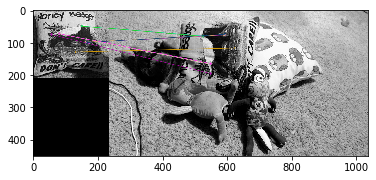

In [6]:
# https://pythonprogramming.net/feature-matching-homography-python-opencv-tutorial/
# brute force" matching. We're going to find all features in both images. Then we match these features.
import numpy as np
import cv2
import matplotlib.pyplot as plt

# template (img1) and the image we're going to search for the template in (img2).
img1 = cv2.imread('opencv-feature-matching-template.jpg',0)
img2 = cv2.imread('opencv-feature-matching-image.jpg',0)

orb = cv2.ORB_create() # This is the detector we're going to use for the features.

kp1, des1 = orb.detectAndCompute(img1,None) # we find the key points and their descriptors with the orb detector.
kp2, des2 = orb.detectAndCompute(img2,None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) # BFMatcher object.

matches = bf.match(des1,des2) # matches of the descriptors, then we sort them based on their distances
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None, flags=2) # drawn the first 10 matches.
plt.imshow(img3)
plt.show()

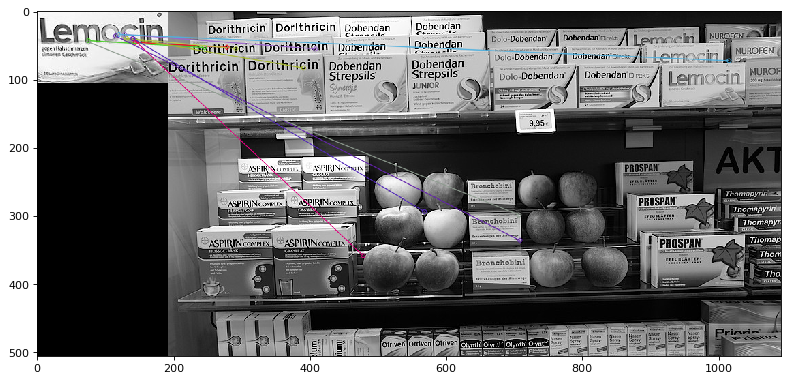

In [51]:
# https://pythonprogramming.net/feature-matching-homography-python-opencv-tutorial/
# brute force" matching. We're going to find all features in both images. Then we match these features.
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# template (img1) and the image we're going to search for the template in (img2).
img1 = cv2.imread('lemocin.jpg',0)
img2 = cv2.imread('aporegal.jpg',0)

orb = cv2.ORB_create() # This is the detector we're going to use for the features.

kp1, des1 = orb.detectAndCompute(img1,None) # we find the key points and their descriptors with the orb detector.
kp2, des2 = orb.detectAndCompute(img2,None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) # BFMatcher object.

matches = bf.match(des1,des2) # matches of the descriptors, then we sort them based on their distances
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None, flags=2) # drawn the first 10 matches.

figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

plt.imshow(img3)
plt.show()

In [30]:
import cv2

method = cv2.TM_SQDIFF

# Read the images from the file
small_image = cv2.imread('lemocin.jpg')
large_image = cv2.imread('aporegal.jpg')

result = cv2.matchTemplate(small_image, large_image, method)

# We want the minimum squared difference
mn,_,mnLoc,_ = cv2.minMaxLoc(result)

# Draw the rectangle:
# Extract the coordinates of our best match
MPx,MPy = mnLoc

# Step 2: Get the size of the template. This is the same size as the match.
trows,tcols = small_image.shape[:2]

# Step 3: Draw the rectangle on large_image
cv2.rectangle(large_image, (MPx,MPy),(MPx+tcols,MPy+trows),(0,0,255),2)

# Display the original image with the rectangle around the match.
cv2.imshow('output',large_image)

# The image is only displayed if we call this
cv2.waitKey(0)

-1

In [29]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img_rgb = cv2.imread('aporegal.jpg')
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread('aspc cplx tmp.jpg',0)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_SQDIFF_NORMED)
threshold = 0.9
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

cv2.imwrite('res.png',img_rgb)

True

In [50]:
import cv2
import numpy as np

img_rgb = cv2.imread('aporegal.jpg')
template = cv2.imread('aspc-tmplt.jpg')
w, h = template.shape[:-1]

res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
threshold = .35
loc = np.where(res >= threshold)
for pt in zip(*loc[::-1]):  # Switch collumns and rows
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)

cv2.imwrite('result.png', img_rgb)

True

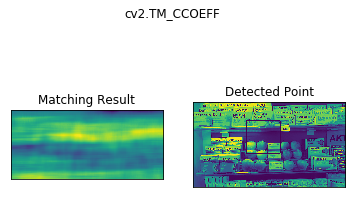

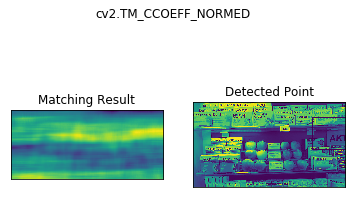

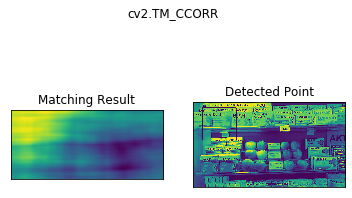

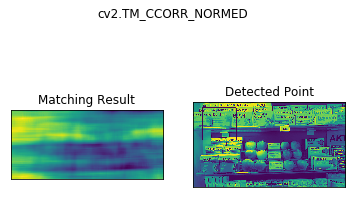

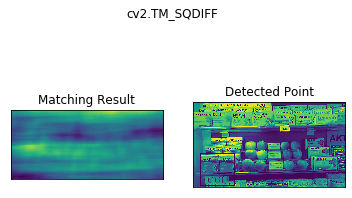

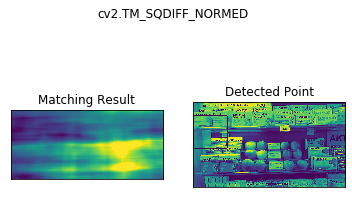

In [53]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('aporegal.jpg',0)
img2 = img.copy()
template = cv2.imread('aspc-tmplt.jpg',0)
w, h = template.shape[::-1]

# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img = img2.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, (0,0,255), 4)

    plt.subplot(121),plt.imshow(res, cmap='viridis') # cmap='gry'
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img, cmap='viridis')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)

    plt.show()

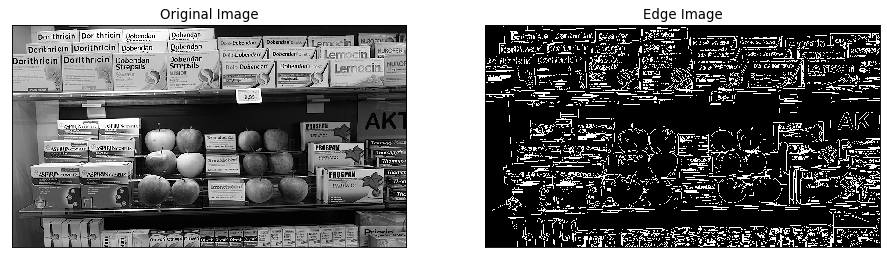

In [57]:
# train packshots

# split image in ever larger patches (maybe use edge detection)

# run recognition on each patch

import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('aporegal.jpg',0)
edges = cv2.Canny(img,100,200)

figure(num=None, figsize=(14, 12), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

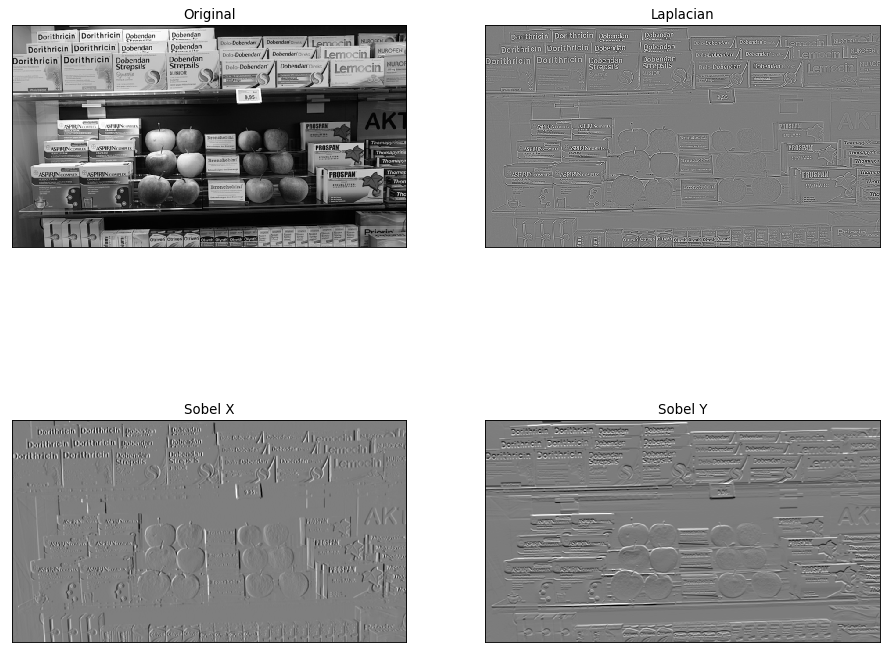

In [59]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# loading image
#img0 = cv2.imread('SanFrancisco.jpg',)
img0 = cv2.imread('aporegal.jpg',)

# converting to gray scale
gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)

# remove noise
img = cv2.GaussianBlur(gray,(3,3),0)

# convolute with proper kernels
laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)  # x
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)  # y

figure(num=None, figsize=(14, 12), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Fourier transform')

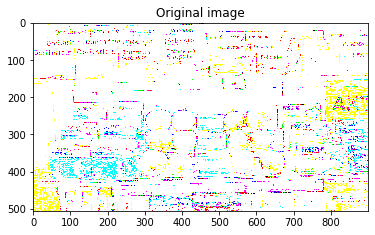

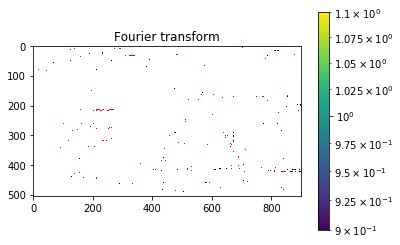

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack

im = plt.imread('aporegal.jpg').astype(float)

plt.figure()
plt.imshow(im, plt.cm.gray)
plt.title('Original image')

im_fft = fftpack.fft2(im, axes=-1)

# Show the results

def plot_spectrum(im_fft):
    from matplotlib.colors import LogNorm
    # A logarithmic colormap
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=1))
    plt.colorbar()

plt.figure()
plot_spectrum(im_fft)
plt.title('Fourier transform')

# In the lines following, we'll make a copy of the original spectrum and
# truncate coefficients.

# Define the fraction of coefficients (in each direction) we keep
#keep_fraction = 0.1

# Call ff a copy of the original transform. Numpy arrays have a copy
# method for this purpose.
#im_fft2 = im_fft.copy()

# Set r and c to be the number of rows and columns of the array.
#r, c = im_fft2.shape

# Set to zero all rows with indices between r*keep_fraction and
# r*(1-keep_fraction):
#im_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0

# Similarly with the columns:
#im_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0

#plt.figure()
#plot_spectrum(im_fft2)
#plt.title('Filtered Spectrum')

# Reconstruct the denoised image from the filtered spectrum, keep only the
# real part for display.
#im_new = fftpack.ifft2(im_fft2).real

#plt.figure()
#plt.imshow(im_new, plt.cm.gray)
#plt.title('Reconstructed Image')

(Text(0.5, 1.0, 'After FFT'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

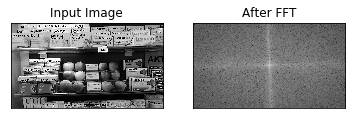

In [7]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('aporegal.jpg', 0)
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

plt.subplot(2, 2, 1), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 2), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('After FFT'), plt.xticks([]), plt.yticks([])

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log


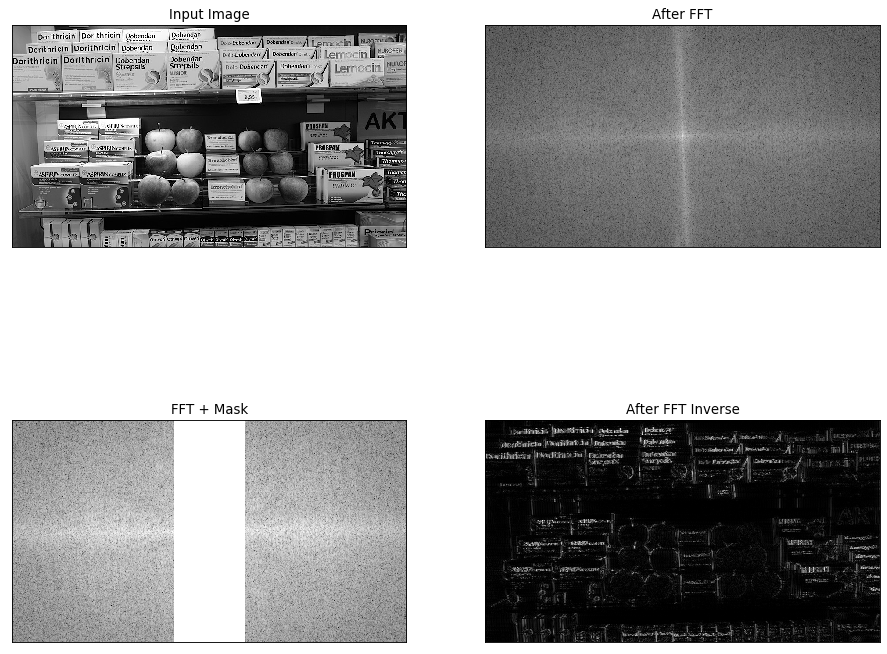

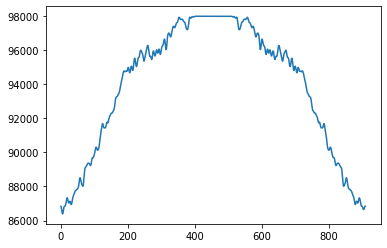

[[  8  30  25  13  10  19  14  51   5   7   9  10  18  21   8   9  10   7
   16  13  14  17   8  24   8 124   8  24   8  17  14  13  16   7  10   9
    8  21  18  10   9   7   5  51  14  19  10  13  25  30   8]]


In [3]:
# https://akshaysin.github.io/fourier_transform.html

import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.signal import argrelextrema
from scipy import fftpack

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError # "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError # "Input vector needs to be bigger than window size."

    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError # "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

img = cv2.imread('aporegal.jpg', 0)
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

#plt.subplot(2, 2, 1), plt.imshow(img, cmap='gray')
#plt.title('Input Image'), plt.xticks([]), plt.yticks([])
#plt.subplot(2, 2, 2), plt.imshow(magnitude_spectrum, cmap='gray')
#plt.title('After FFT'), plt.xticks([]), plt.yticks([])

rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)  # center

# Circular LPF mask, center circle is 1, remaining all zeros
#mask = np.zeros((rows, cols, 2), np.uint8)
#r = 100
#center = [crow, ccol]
#x, y = np.ogrid[:rows, :cols]
#mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
#mask[mask_area] = 1

# Circular HPF mask, center circle is 0, remaining all ones
mask = np.ones((rows, cols, 2), np.uint8)
r = 80
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
#mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r # circular
#mask_area = abs((x - center[0]) + y * 0.)  <= r # directional x
mask_area = abs(x * 0. + (y - center[1]))  <= r # directional y
mask[mask_area] = 0

# apply mask and inverse DFT
fshift = dft_shift * mask

fshift_mask_mag = 2000 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))

f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

plt.figure(num=None, figsize=(14, 12), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2, 2, 1), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 2), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('After FFT'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 3), plt.imshow(fshift_mask_mag, cmap='gray')
plt.title('FFT + Mask'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 4), plt.imshow(img_back, cmap='gray')
plt.title('After FFT Inverse'), plt.xticks([]), plt.yticks([])
plt.show()

clp_spectrum = smooth(np.clip(np.sum(magnitude_spectrum, axis=0), a_min = 0, a_max = 98000))
#clp_spectrum = smooth(clp_spectrum)
plt.plot(range(len(clp_spectrum)), clp_spectrum)
plt.show()

#np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True]
#print(argrelextrema(clp_spectrum, np.greater)) # print local maxima
maxsrt = np.array(argrelextrema(clp_spectrum, np.greater))
print(np.diff(maxsrt))

In [18]:
# D&D chromosomes (from Munroes What if)
import random

def ddstat(): # strict ;)
    return random.randint(1,6) + random.randint(1,6) + random.randint(1,6)

def createcset(l):
    res = []
    for i in range(l-1):
        if random.random() > 0.8:
            res.append(-random.uniform(0.5, 2.5)) # multiplier
        else:
            res.append(ddstat())
    res.append(random.choice([-1, 1]))
    return res

def combine(cset0, cset1):
    if len(cset0) != len(cset1):
        return -1
    res = []
    for ic in range(len(cset0)-1):
        if cset0[ic] < 0: # multipliers are negative
            if cset1[ic] < 0:
                res.append(1)
            else:
                res.append(-cset0[ic] * cset1[ic])
        else:
            if cset1[ic] < 0:
                res.append(-cset0[ic] * cset1[ic])
            else:
                res.append(max(cset0[ic], cset1[ic]))
    if cset0[len(cset0)-1] < 0:
        if cset1[len(cset1)-1] < 0:
            res.append(-1) # female
        else:
            if random.random() > 0.5:
                res.append(1)
            else:
                res.append(-1)
    else:
        if cset1[len(cset1)-1] < 0:
            if random.random() > 0.5:
                res.append(1)
            else:
                res.append(-1)
        else:
            res.append(1) # male
    return res

if __name__=="__main__":
    print(combine([15, -2, -1, 12, -0.5, 14, -1], [5, 12, 14, -1.5, 14, 15, -1]))
    print(ddstat())
    print(createcset(7))
    print(combine(createcset(7), createcset(7)))

[15, 24, 14, 18.0, 7.0, 15, -1]
15
[12, -1.3942079797005587, 10, -0.9509476214283867, 16, 12, -1]
[12, 11, 16.116394728155125, 12, 15.16215490833788, 10.120120109907148, 1]
